In [1]:
import torch
import sys
import os
import pandas as pd
from scipy import misc
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import glob
import imageio
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
LS = 128 #Latent Space Size
batch_size = 99
ColorsNumber = 1

#Encoder param
EncKernel = [5,4,4,4,4,1,1]
EncStride = [1,2,1,2,1,1,1]
EncDepth = [32,64,128,256,512,512,LS]

#Generator param
GenKernel = [4,4,4,4,5,1,1]
GenStride = [1,2,1,2,1,1,1]
GenDepth = [256,128,64,32,32,32,ColorsNumber]

#Discriminator X param
DxKernel = [5,4,4,4,4]
DxStride = [1,2,1,2,1]
DxDepth = [32,64,128,256,512]

#Discriminator Z param
DzKernel = [1,1]
DzStride = [1,1]
DzDepth = [512,512]

#Concat Discriminator param
DxzKernel = [1,1,1]
DxzStride = [1,1,1]
DxzDepth = [1024,1024,1]



In [3]:
datadir = "./images/"


In [4]:
class XrayDataset(Dataset):

    def __init__(self, datadir, transform=None, nrows=None):

        self.datadir = datadir
        self.transform = transform
        self.ImgFiles = [f.split('/')[-1] for f in glob.glob(datadir+"*.png")]

    def __len__(self):
        return len(self.ImgFiles)

    def __getitem__(self, idx):
        im = imageio.imread(os.path.join(self.datadir, self.ImgFiles[idx]))
        
        #Add color chanel
        im = im[:,:,None]
        # Tranform
        if self.transform:
            im = self.transform(im)
        return im
class Iterator:
    """
    iterator over dataloader which automatically resets when all samples have been seen
    """
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.cpt = 0
        self.len = len(self.dataloader)
        self.iterator = iter(self.dataloader)

    def next(self):
        if self.cpt == self.len:
            self.cpt = 0
            self.iterator = iter(self.dataloader)
        self.cpt += 1
        return self.iterator.next()

In [5]:
# Transformations
inputsize = [224, 224]
inputsize = [32,32]
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(inputsize),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize dataloader
dataset = XrayDataset(datadir, transform=data_transforms)
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

print(len(dataset))

501


torch.Size([1, 1, 32, 32])


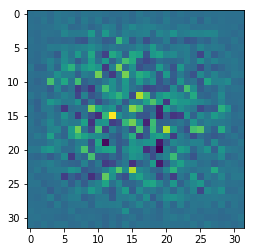

In [6]:
import torch.nn as nn
import torch.nn.functional as F
# Generator Code

class Generator(nn.Module):
    def __init__(self, latent_size=32,output_shape=224,nc=1,KS= [4,221],ST = [1,1],DP=[1,1]):
        
        self.latent_size = latent_size
        self.output_shape = output_shape
        self.nc = nc
        
        
        super(Generator, self).__init__()
        
        
        #Build ConvTranspose layer
        self.main = torch.nn.Sequential()
        lastdepth = self.latent_size
        OldDim = 1
        for i in range(len(KS)):
            kernel_size = KS[i]
            stride = ST[i]
            padding = 0
            output_pading = 0
            
            nnc = DP[i]
            if i == len(KS)-1:
                nnc = 1
            self.main.add_module("ConvT_"+str(i), torch.nn.ConvTranspose2d(lastdepth,nnc,kernel_size,stride,padding,output_pading,bias=False))
            if i != len(KS) - 1:
                self.main.add_module("BN_"+str(i), torch.nn.BatchNorm2d(nnc))
                self.main.add_module("Relu_"+str(i), torch.nn.ReLU(True))
            
            OldDim = (OldDim-1)*stride+kernel_size - 2*padding + output_pading
            lastdepth = nnc
            #print("I=%d K=%d ST=%d Size=%d" % (i,kernel_size,stride,OldDim))
            
            
        self.main.add_module("Sigmoid",nn.Sigmoid())
       

    def forward(self, input):
        return self.main(input)

    
    
GenX = Generator(latent_size=LS,KS=GenKernel,ST=GenStride,DP=GenDepth)
fkim = GenX(torch.rand(1,LS,1,1))
print(fkim.shape)
plt.imshow(fkim.detach().numpy()[0][0])
plt.show()

In [21]:
class Maxout(Function):

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, input):
        x = input
        max_out=4    #Maxout Parameter
        kernels = x.shape[1]  # to get how many kernels/output
        feature_maps = int(kernels / max_out)
        out_shape = (x.shape[0], feature_maps, max_out, x.shape[2], x.shape[3])
        x= x.view(out_shape)
        y, indices = torch.max(x[:, :, :], 2)
        ctx.save_for_backward(input)
        ctx.indices=indices
        ctx.max_out=max_out
        return y

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        input1,indices,max_out= ctx.saved_variables[0],Variable(ctx.indices),ctx.max_out
        input=input1.clone()
        for i in range(max_out):
            a0=indices==i
            input[:,i:input.data.shape[1]:max_out]=a0.float()*grad_output
      

        return input


NameError: name 'Function' is not defined

In [25]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

class DiscriminatorX(nn.Module):
    def __init__(self,KS,ST,DP):
        super(DiscriminatorX, self).__init__()
        
        
        #Build ConvTranspose layer
        self.main = torch.nn.Sequential()
        
        
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0
        
        self.main = torch.nn.Sequential()
        lastdepth = 1
        nnc = 1
        for i in range(len(KS)):
            
            kernel_size = KS[i]
            stride = ST[i]
            nnc = DP[i]
            
            padding = 0
            output_pading = 0
            
            self.main.add_module("ConvT_"+str(i), 
                                 torch.nn.Conv2d(in_channels=lastdepth,out_channels=nnc,
                                                 kernel_size=kernel_size,stride=stride,bias=False))
           
            if i != len(KS) - 1:
                self.main.add_module("BN_"+str(i), torch.nn.BatchNorm2d(nnc))
                self.main.add_module("LRelu_"+str(i), torch.nn.LeakyReLU(0.1, inplace=True))
            
            lastdepth = nnc
           
       

    def forward(self, input):
        return self.main(input)


    
    
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

class DiscriminatorZ(nn.Module):
    def __init__(self,KS,ST,DP,LS):
        super(DiscriminatorZ, self).__init__()
        
        
        #Build ConvTranspose layer
        self.main = torch.nn.Sequential()
        
        
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0
        
        self.main = torch.nn.Sequential()
        lastdepth = LS
        nnc = 1
        for i in range(len(KS)):
            
            kernel_size = KS[i]
            stride = ST[i]
            nnc = DP[i]
            
            padding = 0
            output_pading = 0
            
            self.main.add_module("ConvT_"+str(i), 
                                 torch.nn.Conv2d(in_channels=lastdepth,out_channels=nnc,
                                                 kernel_size=kernel_size,stride=stride,bias=False))
           
            if i != len(KS) - 1:
                self.main.add_module("BN_"+str(i), torch.nn.BatchNorm2d(nnc))
                self.main.add_module("LRelu_"+str(i), torch.nn.LeakyReLU(0.1, inplace=True))
            
            lastdepth = nnc
           
       

    def forward(self, input):
        return self.main(input)


    
class DiscriminatorXZ(nn.Module):
    def __init__(self,KS,ST,DP):
        super(DiscriminatorXZ, self).__init__()
        
        
        #Build ConvTranspose layer
        self.main = torch.nn.Sequential()
        
        
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0
        
        self.main = torch.nn.Sequential()
        lastdepth = 1024
        nnc = 1
        for i in range(len(KS)):
            
            kernel_size = KS[i]
            stride = ST[i]
            nnc = DP[i]
            
            padding = 0
            output_pading = 0
            
            self.main.add_module("ConvT_"+str(i), 
                                 torch.nn.Conv2d(in_channels=lastdepth,out_channels=nnc,
                                                 kernel_size=kernel_size,stride=stride,bias=False))
           
            if i != len(KS) - 1:
                self.main.add_module("Dropout_"+str(i), torch.nn.Dropout(0.5))
                #self.main.add_module("Maxout_"+str(i),Maxout)
.                
            lastdepth = nnc
        #self.main.add_module("Sigmoid", torch.nn.Sigmoid())
       

    def forward(self, input):
        return self.main(input)



IndentationError: unindent does not match any outer indentation level (<tokenize>, line 121)

In [8]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

class Encoder(nn.Module):
    def __init__(self,KS,ST,DP,LS):
        super(Encoder, self).__init__()
        
        
        #Build ConvTranspose layer
        self.main = torch.nn.Sequential()
        
        
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0
        
        self.main = torch.nn.Sequential()
        lastdepth = 1
        nnc = 1
        for i in range(len(KS)):
            
            kernel_size = KS[i]
            stride = ST[i]
            nnc = DP[i]
            
            padding = 0
            output_pading = 0
            
            self.main.add_module("ConvT_"+str(i), 
                                 torch.nn.Conv2d(in_channels=lastdepth,out_channels=nnc,
                                                 kernel_size=kernel_size,stride=stride,bias=False))
           
            if i != len(KS) - 1:
                self.main.add_module("BN_"+str(i), torch.nn.BatchNorm2d(nnc))
                self.main.add_module("LRelu_"+str(i), torch.nn.LeakyReLU(0.2, inplace=True))
            
            lastdepth = nnc
    
       

    def forward(self, input):
        return self.main(input)



In [9]:
import torch.optim as optim




DisX = DiscriminatorX(KS=DxKernel,ST=DxStride,DP=DxDepth)
DisZ = DiscriminatorZ(KS=DzKernel,ST=DzStride,DP=DzDepth,LS=LS)
DisXZ = DiscriminatorXZ(KS=DxzKernel,ST=DxzStride,DP=DxzDepth)

GenZ = Encoder(KS=EncKernel,ST=EncStride,DP=EncDepth,LS=LS)
GenX = Generator(latent_size=LS,KS=GenKernel,ST=GenStride,DP=GenDepth)

if torch.cuda.is_available():
    DisX = DiscriminatorX(KS=DxKernel,ST=DxStride,DP=DxDepth).cuda()
    GenX = Generator(latent_size=LS,KS=GenKernel,ST=GenStride,DP=GenDepth).cuda()
    


In [10]:
for dataiter in dataloader:
    #Get Data
    data = dataiter
    data_norm = data*2.0-1.0
    break

In [11]:


lr = 1e-4
b1 = 0.5
b2 = 1e-3
optimizerG = optim.Adam([{'params' : GenX.parameters()},
                         {'params' : GenZ.parameters()}], lr=lr, betas=(b1,b2))

optimizerD = optim.Adam([{'params' : DisZ.parameters()},{'params': DisX.parameters()},
                         {'params' : DisXZ.parameters()}], lr=lr, betas=(b1,b2))

DiscriminatorLoss = []


1 torch.Size([99, 1, 32, 32])
2 torch.Size([99, 1, 32, 32])
3 torch.Size([99, 1, 32, 32])
4 torch.Size([99, 1, 32, 32])
5 torch.Size([99, 1, 32, 32])
6 torch.Size([6, 1, 32, 32])


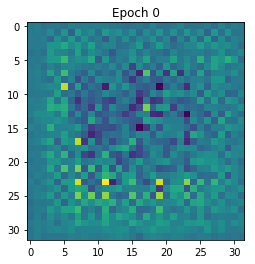

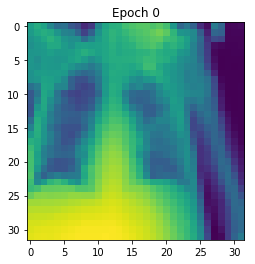

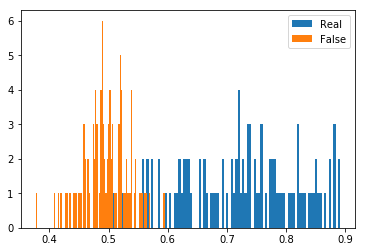

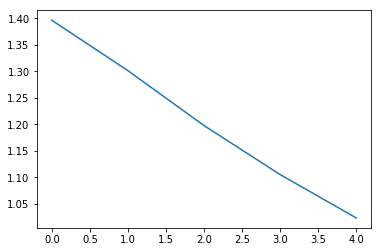

1 torch.Size([99, 1, 32, 32])
2 torch.Size([99, 1, 32, 32])
3 torch.Size([99, 1, 32, 32])
4 torch.Size([99, 1, 32, 32])
5 torch.Size([99, 1, 32, 32])
6 torch.Size([6, 1, 32, 32])


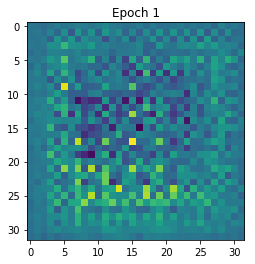

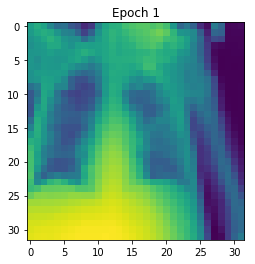

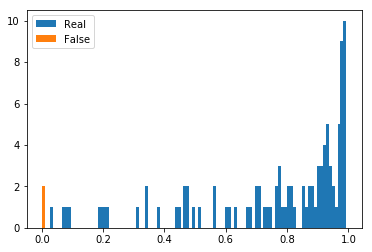

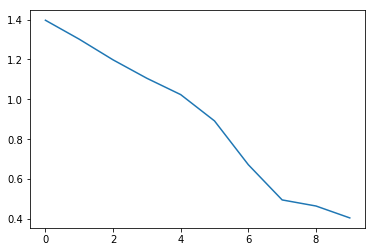

1 torch.Size([99, 1, 32, 32])
2 torch.Size([99, 1, 32, 32])
3 torch.Size([99, 1, 32, 32])
4 torch.Size([99, 1, 32, 32])
5 torch.Size([99, 1, 32, 32])
6 torch.Size([6, 1, 32, 32])


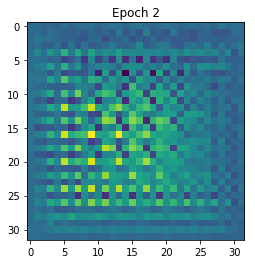

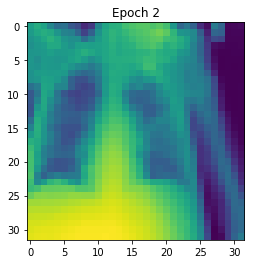

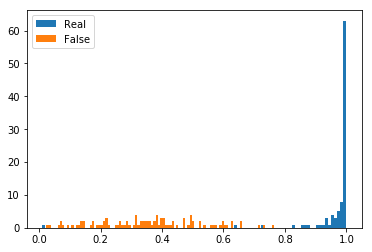

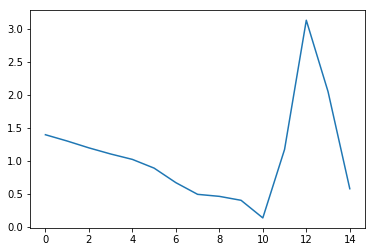

1 torch.Size([99, 1, 32, 32])
2 torch.Size([99, 1, 32, 32])
3 torch.Size([99, 1, 32, 32])
4 torch.Size([99, 1, 32, 32])
5 torch.Size([99, 1, 32, 32])
6 torch.Size([6, 1, 32, 32])


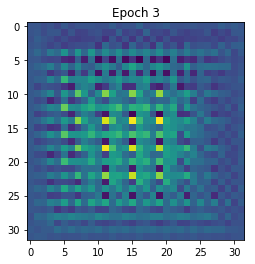

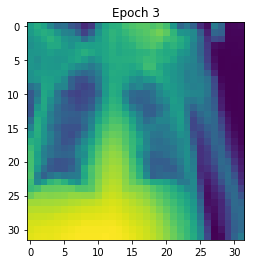

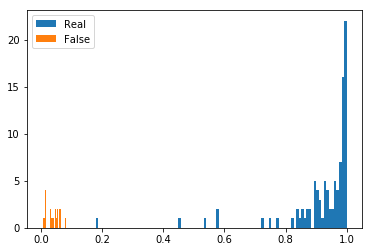

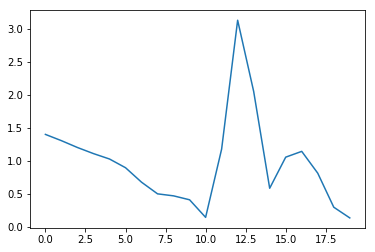

1 torch.Size([99, 1, 32, 32])
2 torch.Size([99, 1, 32, 32])
3 torch.Size([99, 1, 32, 32])
4 torch.Size([99, 1, 32, 32])
5 torch.Size([99, 1, 32, 32])
6 torch.Size([6, 1, 32, 32])


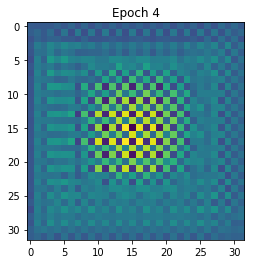

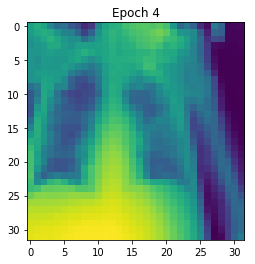

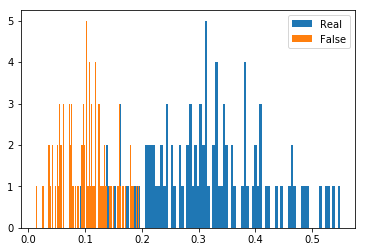

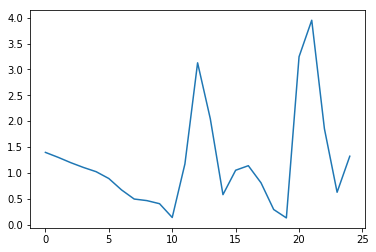

1 torch.Size([99, 1, 32, 32])
2 torch.Size([99, 1, 32, 32])
3 torch.Size([99, 1, 32, 32])
4 torch.Size([99, 1, 32, 32])
5 torch.Size([99, 1, 32, 32])
6 torch.Size([6, 1, 32, 32])


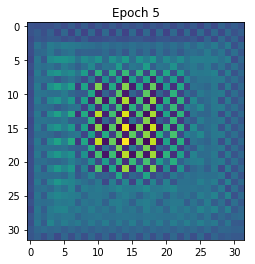

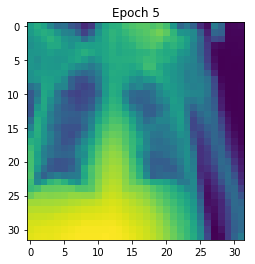

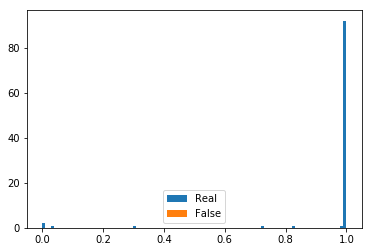

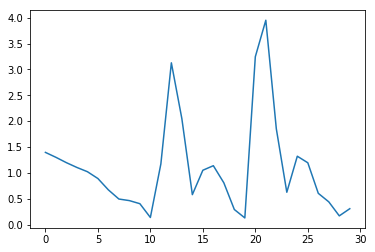

1 torch.Size([99, 1, 32, 32])
2 torch.Size([99, 1, 32, 32])
3 torch.Size([99, 1, 32, 32])
4 torch.Size([99, 1, 32, 32])
5 torch.Size([99, 1, 32, 32])
6 torch.Size([6, 1, 32, 32])


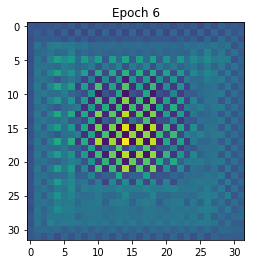

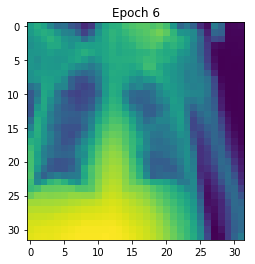

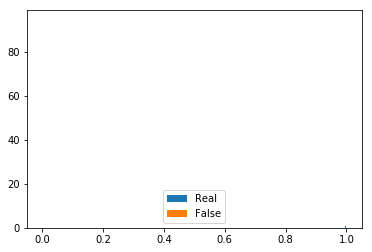

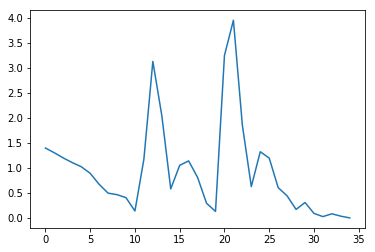

1 torch.Size([99, 1, 32, 32])
2 torch.Size([99, 1, 32, 32])
3 torch.Size([99, 1, 32, 32])
4 torch.Size([99, 1, 32, 32])
5 torch.Size([99, 1, 32, 32])
6 torch.Size([6, 1, 32, 32])


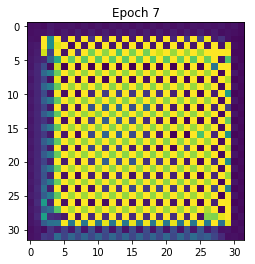

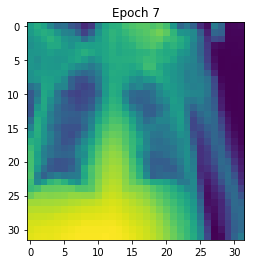

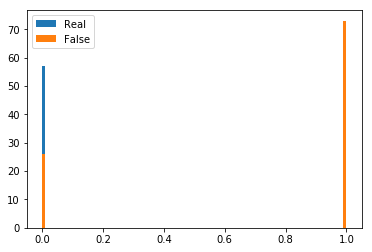

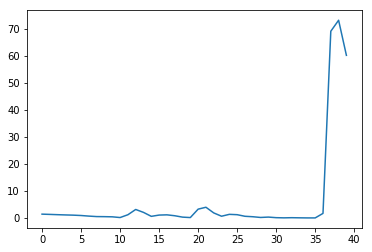

1 torch.Size([99, 1, 32, 32])
2 torch.Size([99, 1, 32, 32])
3 torch.Size([99, 1, 32, 32])
4 torch.Size([99, 1, 32, 32])
5 torch.Size([99, 1, 32, 32])


KeyboardInterrupt: 

In [12]:
from torch.autograd import Variable


ConstantZ = torch.randn(9,LS,1,1)

cpt = 0

criterion = nn.BCELoss()
for epoch in range(1):
    
    #Store Discriminator data
    AllRealDisc = []
    AllFakeDisc = []
    
    
    c = 0
    for dataiter in dataloader:
        c += 1
        
        #Get Data
        Xnorm = dataiter
        print(c,Xnorm.shape)
        #To cuda
        if torch.cuda.is_available():
            Xnorm = Xnorm.cuda()
        
        #Get Batch Size
        BS = Xnorm.shape[0]
        if BS < batch_size/2.0:
            continue
        
        #Generate Fake data from random Latent
        FakeZ = torch.randn(BS,LS,1,1)
        FakeX = GenX(FakeZ)
        
        #Generate Latent from Real
        RealZ = GenZ(Xnorm)
        
        #Have discriminator do is thing on real and fake data
        RealCat= torch.cat((DisZ(RealZ), DisX(Xnorm)), 1)
        FakeCat= torch.cat((DisZ(FakeZ), DisX(FakeX)), 1)
        PredReal  = DisXZ(RealCat)
        PredFalse = DisXZ(FakeCat)
        
        #Get loss for discriminator
        loss_d = criterion(PredReal.view(-1), Variable(torch.ones(BS))) + criterion(PredFalse.view(-1), Variable(torch.zeros(BS)))

        #Get loss for generator
        loss_g = criterion(PredFalse.view(-1), Variable(torch.ones(BS))) + criterion(PredReal.view(-1), Variable(torch.zeros(BS)))

        #Optimize Discriminator
        optimizerD.zero_grad()
        loss_d.backward(retain_graph=True)
        optimizerD.step()
    
        #Optimize Generator
        optimizerG.zero_grad()
        loss_g.backward()
        optimizerG.step()
    
    
        #StoreInfo
        DiscriminatorLoss.append(loss_d.detach().numpy()+0)
        AllRealDisc = list(np.ravel(PredReal.detach().numpy()))
        AllFakeDisc = list(np.ravel(PredFalse.detach().numpy()))
        
        
        #break
        
    if epoch % 1 == 0:
        with torch.no_grad():
            FakeData = GenX(ConstantZ).detach().numpy()
            plt.imshow(FakeData[0][0])
            plt.title("Epoch %d" % (epoch))
            plt.show()

            plt.imshow(data[0][0])
            plt.title("Epoch %d" % (epoch))
            plt.show()


            #print("Epoch:%d AUC:%.2f" % (epoch,auc))


            plt.hist(AllRealDisc,100,label="Real")
            plt.hist(AllFakeDisc,100,label="False")
            plt.legend()
            plt.show()


            plt.plot(range(len(DiscriminatorLoss)),DiscriminatorLoss)
            plt.show()

    #break

In [ ]:
c

In [ ]:
FakeData.shape

In [ ]:
FakeData = GenX(ConstantZ).detach().numpy()
plt.figure(figsize=(8,8))

c = 0
for fd in FakeData:
    c +=1
    #print(fd.shape)
    plt.subplot(3,3,c)
    plt.imshow(fd[0])
    plt.axis("off")
plt.show()

In [ ]:
plt.imshow(data[0][0])

In [ ]:
np.min(GenX(ConstantZ).detach().numpy()[0][0])